# Loc/Roc modules applied to vitalDB 

In [2]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal
import os
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import mne

from boost_loc_roc.miscelaneous import *


## Define your criteria and parameters of inerest

In [12]:
# Use the includded file to get available data per id
Data_available = pd.read_csv('data/VdB_tables/Output_existing_data.csv')
Data_available.head()

id  SNUADC/ART  SNUADC/CVP  SNUADC/ECG_II  SNUADC/ECG_V5  \
0  0001.vital           1           0              1              1   
1  0002.vital           0           0              1              1   
2  0003.vital           0           0              1              1   
3  0004.vital           1           0              1              0   
4  0005.vital           1           1              1              1   

   SNUADC/FEM  SNUADC/PLETH  Solar8000/ART_DBP  Solar8000/ART_MBP  \
0           0             1                  1                  1   
1           0             1                  0                  0   
2           0             1                  0                  0   
3           0             1                  1                  1   
4           0             1                  1                  1   

   Solar8000/ART_SBP  ...  CardioQ/SVI  FMS/FLOW_RATE  FMS/INPUT_AMB_TEMP  \
0                  1  ...            0              0                   0   
1                  0  ...            0              0                   0   
2                  0  ...            0              0                   0   
3                  1  ...            0              0                   0   
4                  1  ...            0              1                   1   

   FMS/INPUT_TEMP  FMS/OUTPUT_AMB_TEMP  FMS/OUTPUT_TEMP  FMS/PRESSURE  \
0               0                    0                0             0   
1               0                    0                0             0   
2               0                    0                0             0   
3               0                    0                0             0   
4               1                    1                1             1   

   FMS/TOTAL_VOL  EVENT  Solar8000/GAS2_AGENT  
0              0      1                     1  
1              0      1                     1  
2              0      1                     0  
3              0      1                     1  
4              1      1                     1  

[5 rows x 199 columns]

In [14]:
# Read the relevant parameters from a CSV file into a pandas DataFrame
list_relevant_var = pd.read_csv('data/VdB_tables/Relevant_params.csv')

# Extract Arterial pressure params 
list_PA = list(list_relevant_var['Params'])[0:11]

# Extract Drug params 
list_Drug = list(list_relevant_var['Params'])[11:16]

# Extract EEG pressure params 
list_EEG = list(list_relevant_var['Params'])[29:]

# Display the contents of list_EEG
list_EEG

['BIS/BIS', 'BIS/EEG1_WAV', 'BIS/EEG2_WAV', 'BIS/EMG', 'BIS/SEF', 'BIS/SR']

In [16]:
# make masks based on desired parameters  
mask1 = Data_available[list_PA].any(axis=1)
mask2 = Data_available[['Orchestra/PPF20_CE']].any(axis=1)   # target propofol !!!!
mask3 = Data_available[list_EEG].any(axis=1)

# Apply the masks to filter the DataFrame
filtered_df = Data_available[mask3 & mask2]

# Get the patient IDs from the filtered DataFrame
patient_ids = filtered_df['id']

# Print the patient IDs
print('There are', len(patient_ids), 'ids satisfying your criteria.')

There are 3307 ids satisfying your criteria.


## Make .fif file for LoC/RoC analysis

Creating RawArray with float64 data, n_channels=2, n_times=2755746
    Range : 0 ... 2755745 =      0.000 ... 21529.258 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=927439
    Range : 0 ... 927438 =      0.000 ...  7245.609 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=757232
    Range : 0 ... 757231 =      0.000 ...  5915.867 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=573328
    Range : 0 ... 573327 =      0.000 ...  4479.117 secs
Ready.


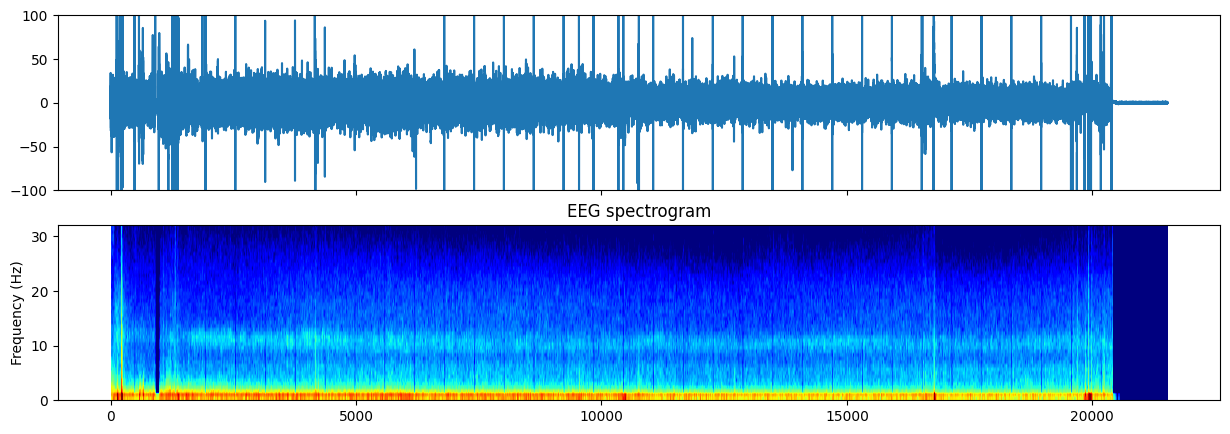

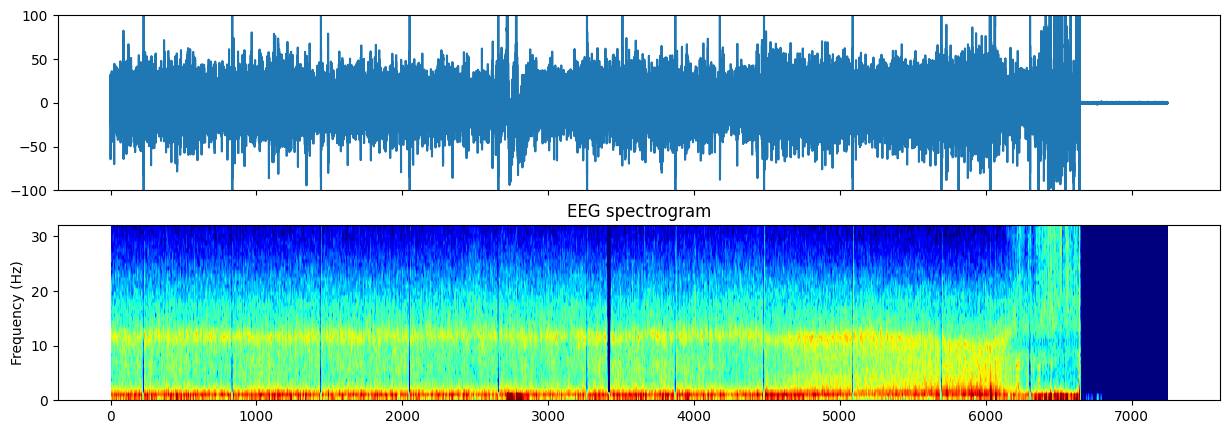

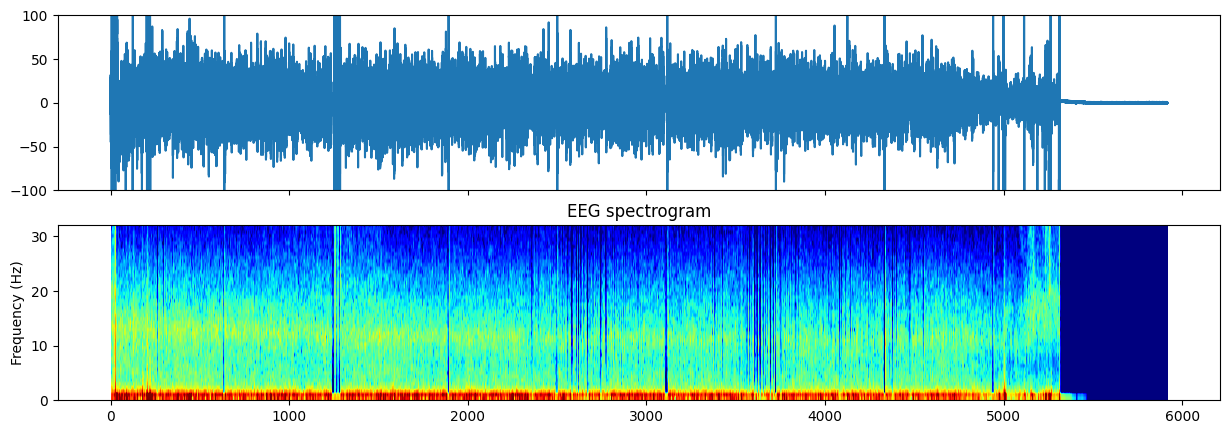

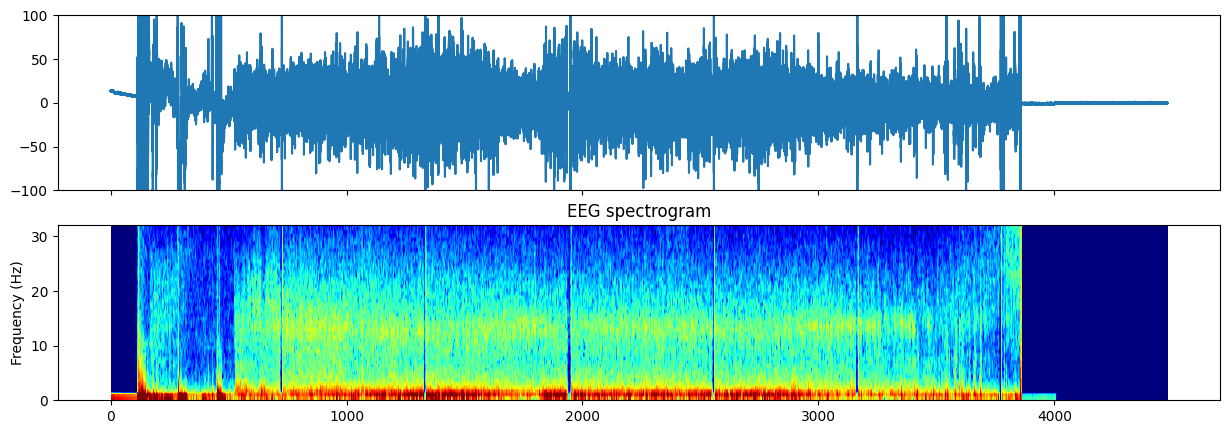

In [26]:
output_file = 'VdB_fif/'

vital_db_directory = "C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/"
# vital_db_directory = '.../VitalDB/vital_files/'
path = vital_db_directory


for i in patient_ids[1:5]:
 
    EEG1 = vitaldb.vital_recs(vital_db_directory+i, ['BIS/EEG1_WAV'], interval=1/128,
                        return_timestamp=True, return_pandas=True)
    EEG2 = vitaldb.vital_recs(vital_db_directory+i, ['BIS/EEG2_WAV'], interval=1/128,
                        return_timestamp=True, return_pandas=True)
    
    # Detrend and reset time
    EEG1 = detrend_and_reset_time(EEG1,  var='BIS/EEG1_WAV', new_name='EEG', trend_wind=300)
    EEG2 = detrend_and_reset_time(EEG2,  var='BIS/EEG2_WAV', new_name='EEG', trend_wind=300) 
        
    # Metadata
    dt = np.nanmedian(np.diff(EEG2['Time'] ))
    sfreq = 1/dt  # Sampling frequency in Hz
    ch_names = ['EEG1', 'EEG2']  # List of channel names
    ch_types = ['eeg', 'eeg']  # Assuming all channels are EEG

    # Step 2: Create an Info structure
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Step 3: Create Raw object
    eeg_data = np.array([EEG1['EEG'].values, EEG2['EEG'].values])
    raw = mne.io.RawArray(eeg_data, info)
    
    # Step 4: Save Raw object to .fif file
    output_fname = f'{i}_eeg.fif'
    

    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 5))
    
    ax[0].plot(EEG2['Time'], EEG2['EEG'].values)
    ax[0].set_ylim([-100, 100])
    
    # Plot spectrogram
    nperseg = int(1.5 * 1/dt)
    noverlap = int(nperseg / 3)
    pxx, freqs, bins, im = ax[1].specgram(EEG2['EEG'].values, Fs=1/dt, NFFT=int(nperseg), mode='psd', cmap='jet', noverlap=int(noverlap))
    im.set_clim(-20, 25)
    ax[1].set_title('EEG spectrogram')
    ax[1].set_ylim([0, 32])
    ax[1].set_ylabel('Frequency (Hz)')
 
    # ! Save the .fif
    # raw.save(output_file + output_fname, overwrite=True)


## Aply Loc/Roc

### Convert if necessary

In [30]:
directory = os.path.join(vital_db_directory, 'VdB_fif')
files = [f for f in os.listdir(directory) if f.endswith('.fif')]

for file in files[0:5]:
    filename = os.path.join(directory, file)
    
    # Read the raw data
    raw = mne.io.read_raw_fif(filename, preload=True)

    # Compute the median of the absolute values of the signal
    median_value = np.median(np.abs(raw.get_data()))
    
    if median_value > 5:      
        # Rescale the signal
        raw._data *= 10**-6
        raw.save(filename, overwrite=True)
    else:
        print("The units are likely already in volts. No rescaling needed.")

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0003.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 562275 =      0.000 ...  4392.773 secs
Ready.
Reading 0 ... 562275  =      0.000 ...  4392.773 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0005.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 2755745 =      0.000 ... 21529.258 secs
Ready.
Reading 0 ... 2755745  =      0.000 ... 21529.258 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0019.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 3529052 =      0.000 ... 27570.719 secs
Ready.
Reading 0 ... 3529052  =      0.000 ... 27570.719 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0003.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 562275 =      0.000 ...  4392.773 secs
Ready.
Reading 0 ... 562275  =      0.000 ...  4392.773 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0003.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 562275 =      0.000 ...  4392.773 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=258917
    Range : 0 ... 258916 =      0.000 ...  4109.778 secs
Ready.
sfreq 63.0
Effective window size : 8.127 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


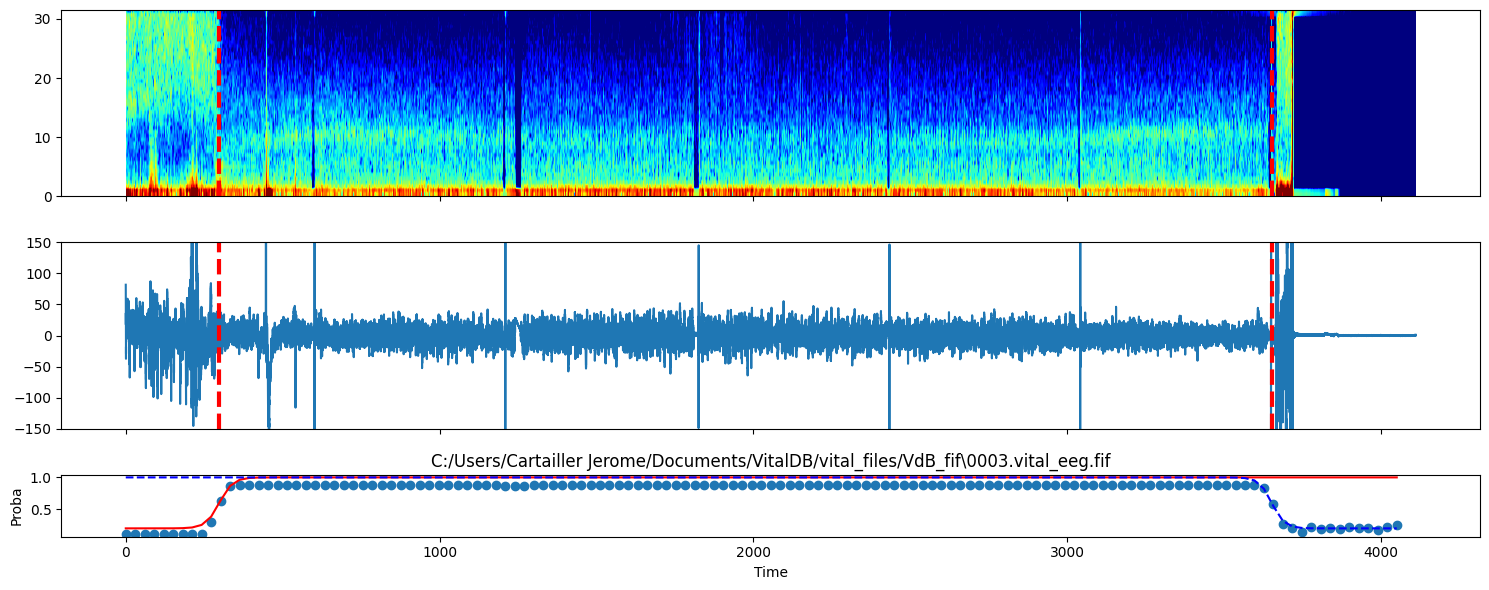

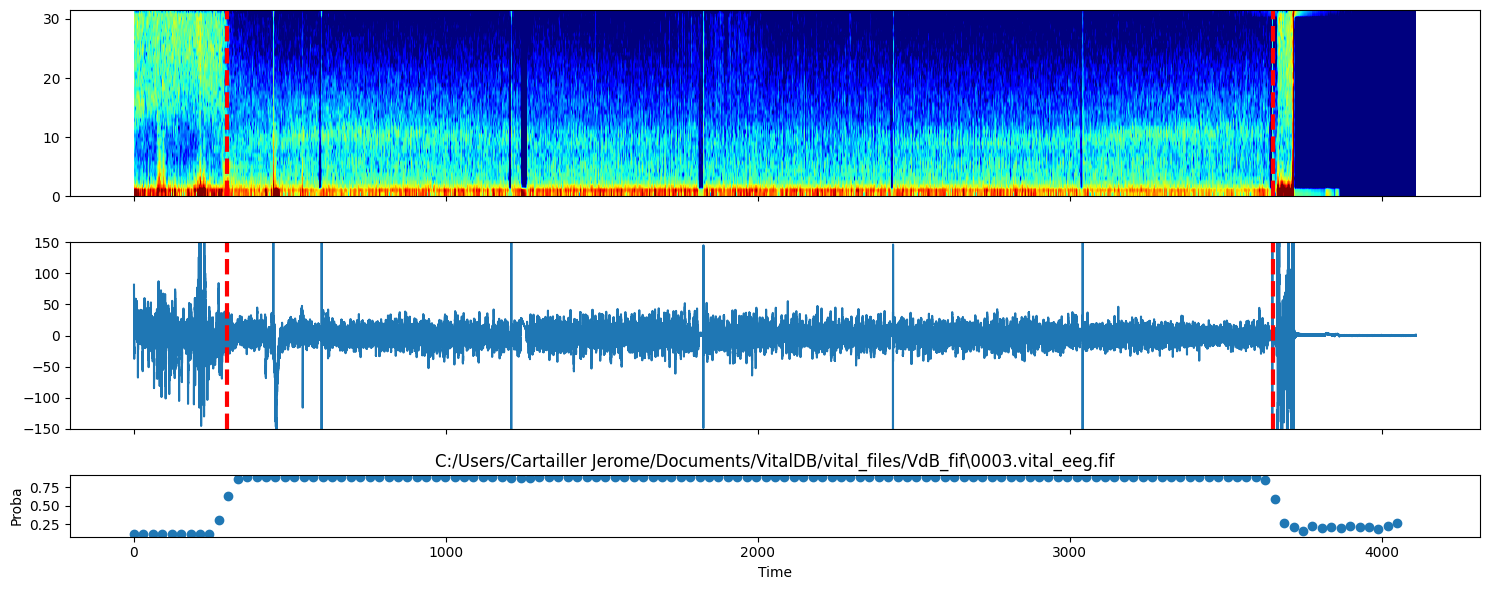

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0005.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 2755745 =      0.000 ... 21529.258 secs
Ready.
Reading 0 ... 2755745  =      0.000 ... 21529.258 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0005.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 2755745 =      0.000 ... 21529.258 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1351195
    Range : 0 ... 1351194 =      0.000 ... 21447.524 secs
Ready.
sfreq 63.0
Effective window size : 8.127 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


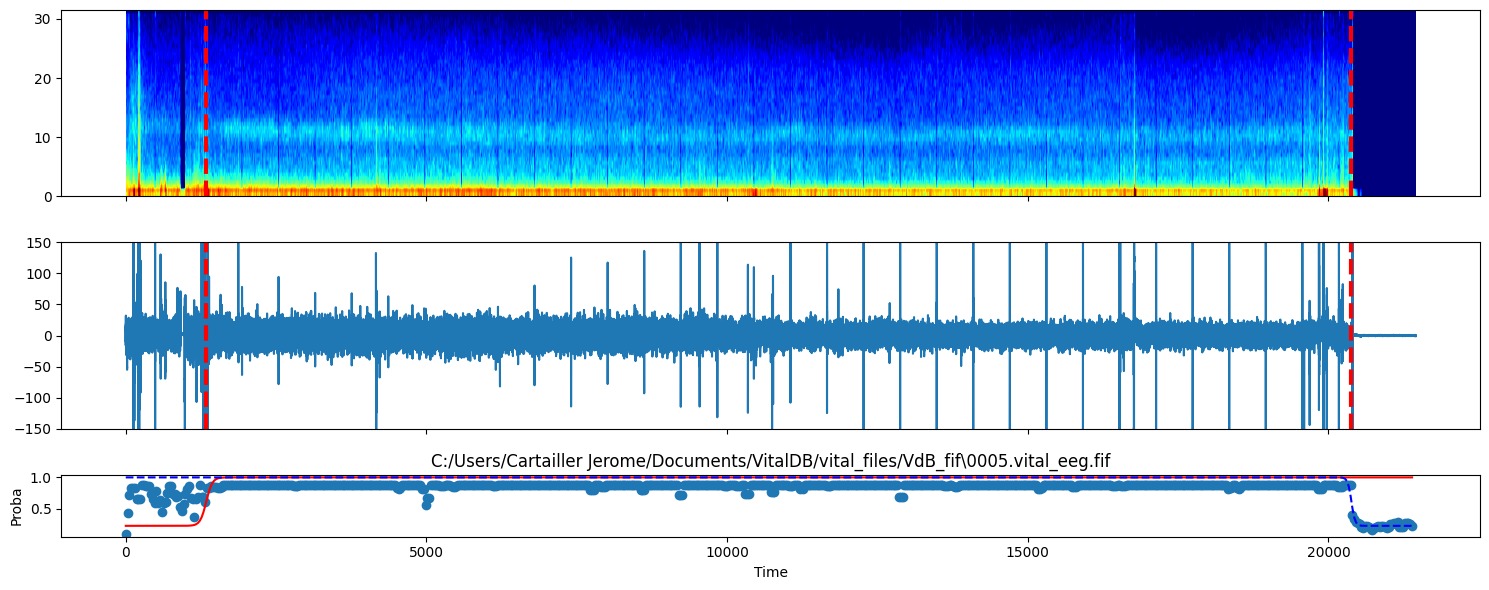

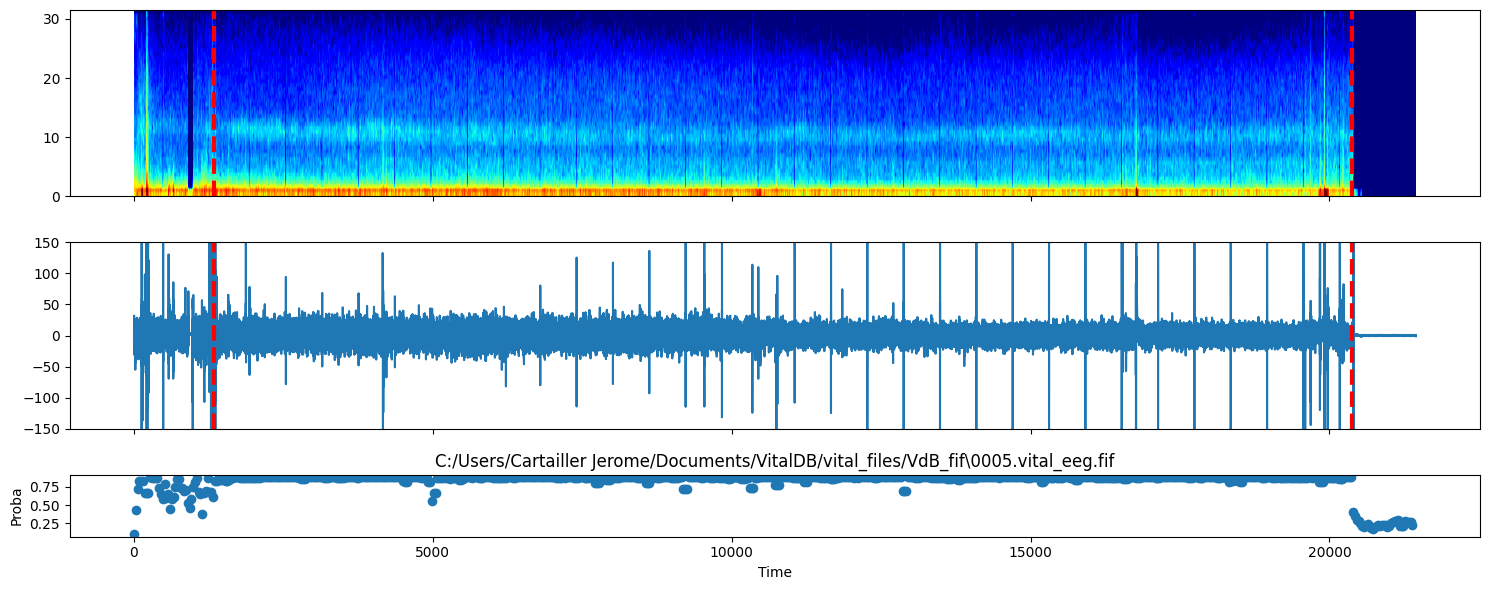

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0019.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 3529052 =      0.000 ... 27570.719 secs
Ready.
Reading 0 ... 3529052  =      0.000 ... 27570.719 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0019.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 3529052 =      0.000 ... 27570.719 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1735825
    Range : 0 ... 1735824 =      0.000 ... 27552.762 secs
Ready.
sfreq 63.0
Effective window size : 8.127 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


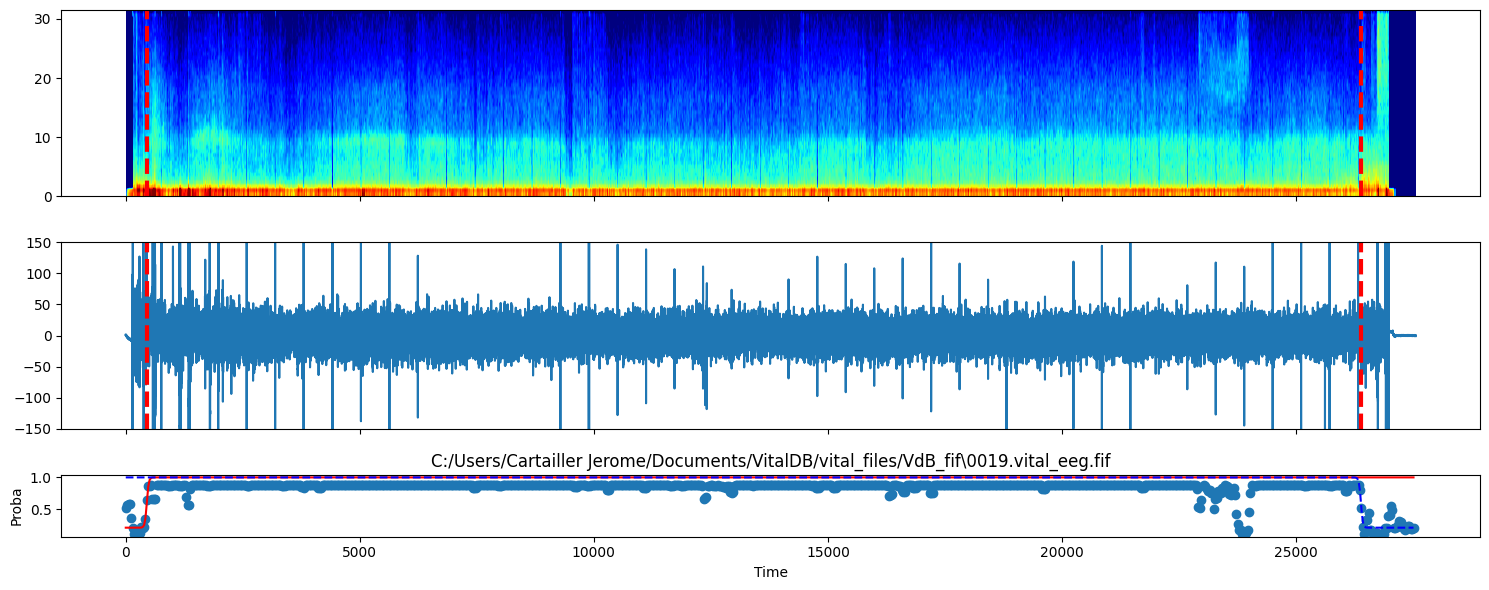

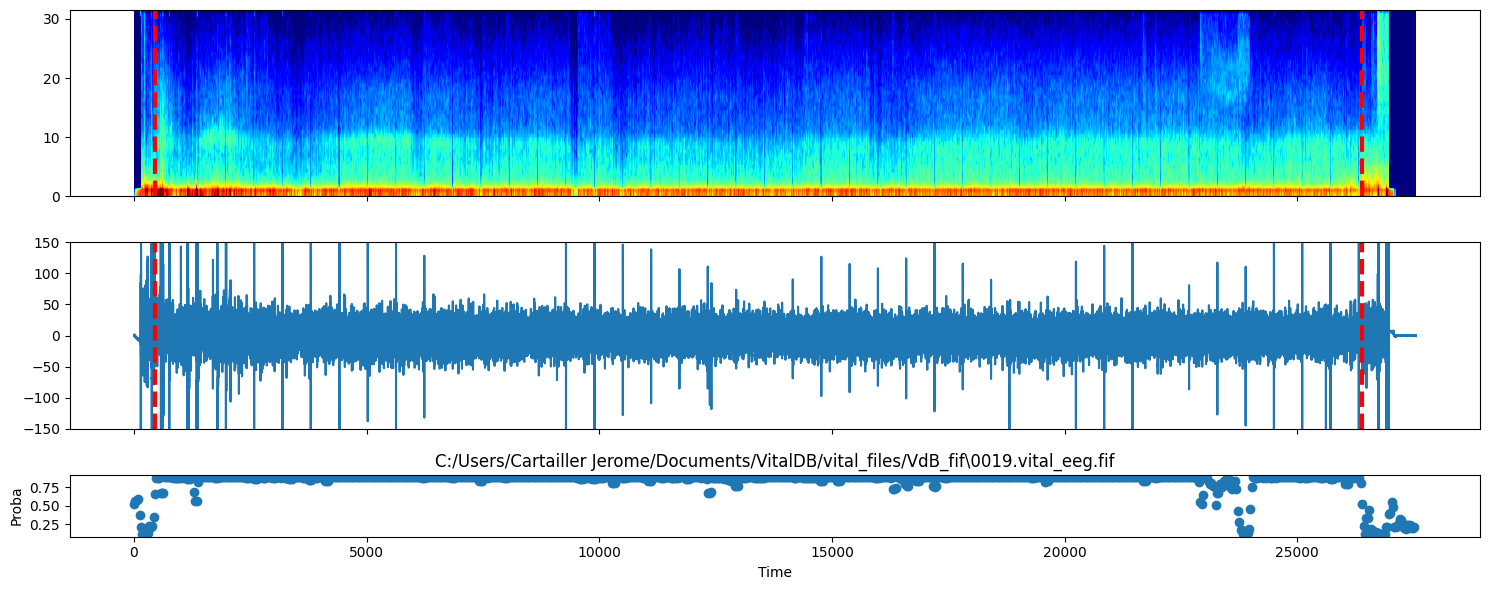

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0020.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 3388662 =      0.000 ... 26473.922 secs
Ready.
Reading 0 ... 3388662  =      0.000 ... 26473.922 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0020.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 3388662 =      0.000 ... 26473.922 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1665625
    Range : 0 ... 1665624 =      0.000 ... 26438.476 secs
Ready.
sfreq 63.0
Effective window size : 8.127 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


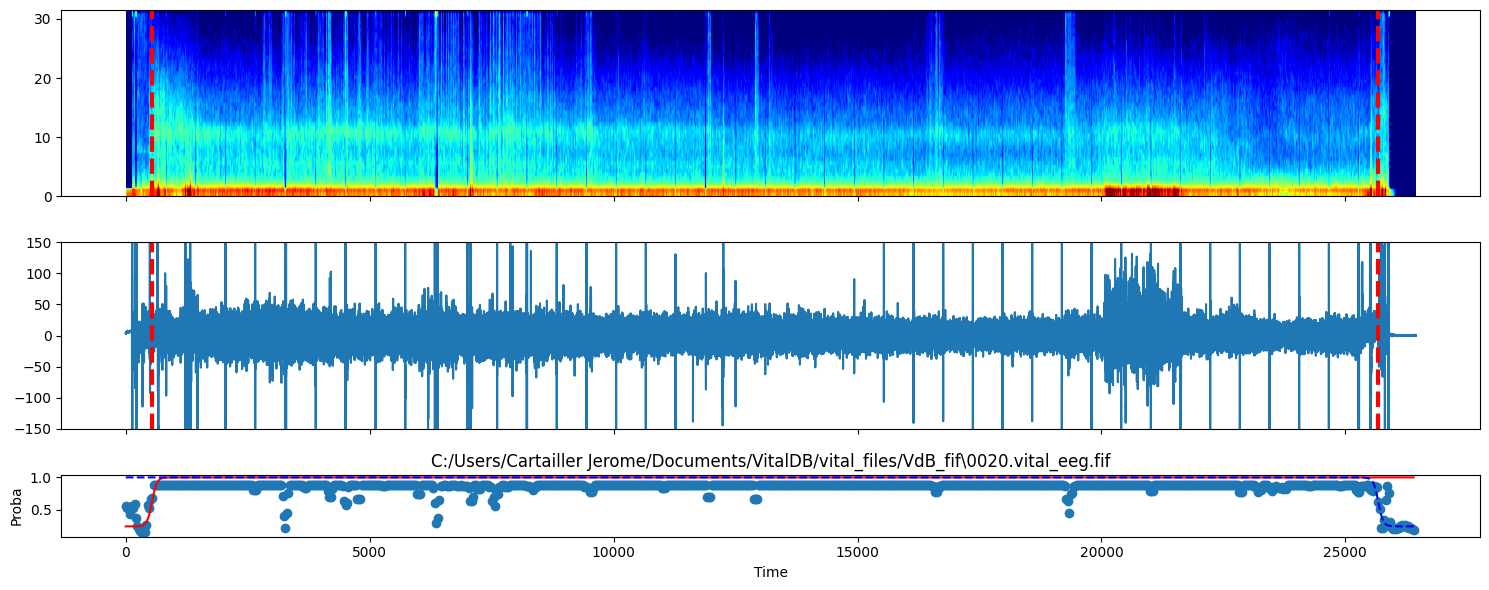

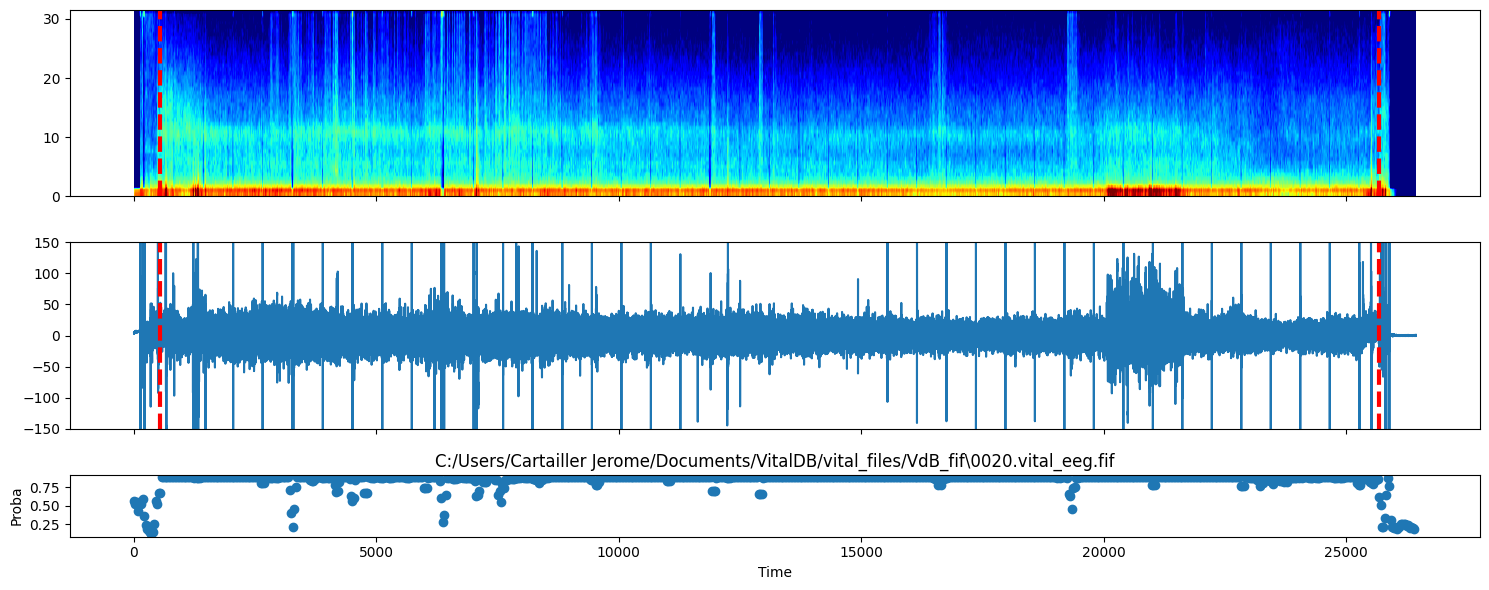

Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0030.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 1423464 =      0.000 ... 11120.812 secs
Ready.
Reading 0 ... 1423464  =      0.000 ... 11120.812 secs...
The units are likely already in volts. No rescaling needed.
Opening raw data file C:/Users/Cartailler Jerome/Documents/VitalDB/vital_files/VdB_fif\0030.vital_eeg.fif...
Isotrak not found
    Range : 0 ... 1423464 =      0.000 ... 11120.812 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=691487
    Range : 0 ... 691486 =      0.000 ... 10975.968 secs
Ready.
sfreq 63.0
Effective window size : 8.127 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Cartailler Jerome\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


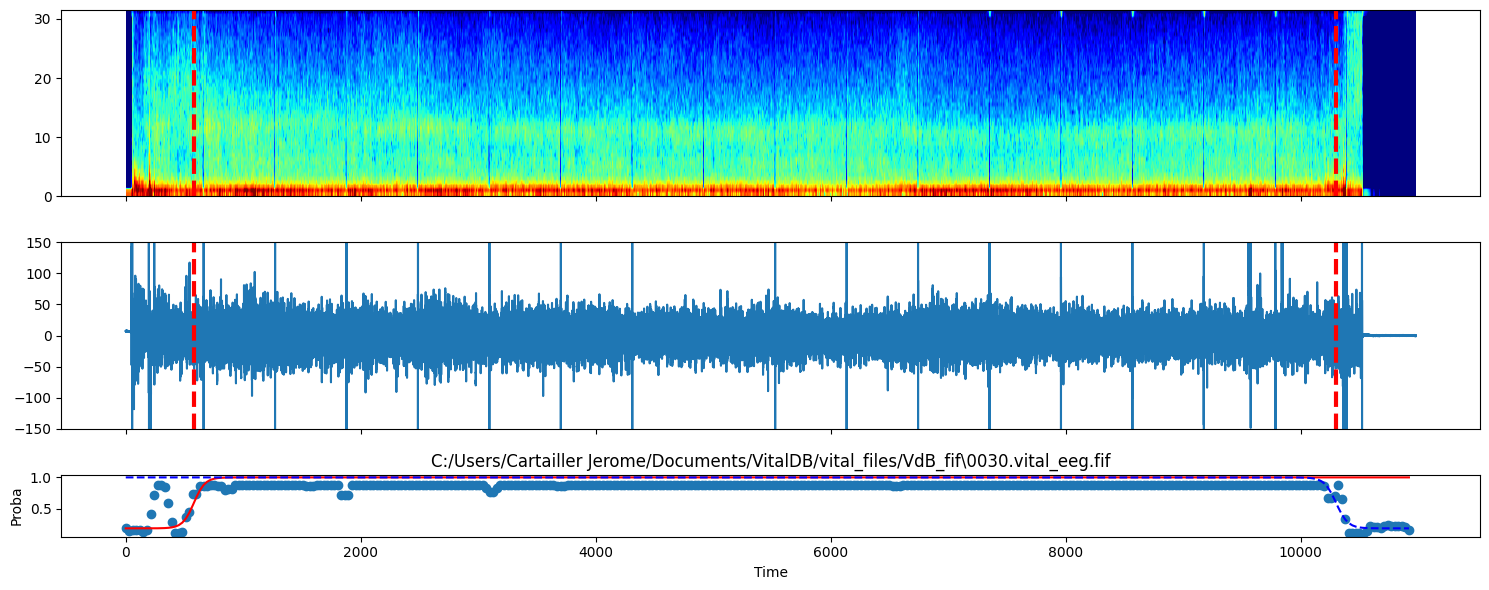

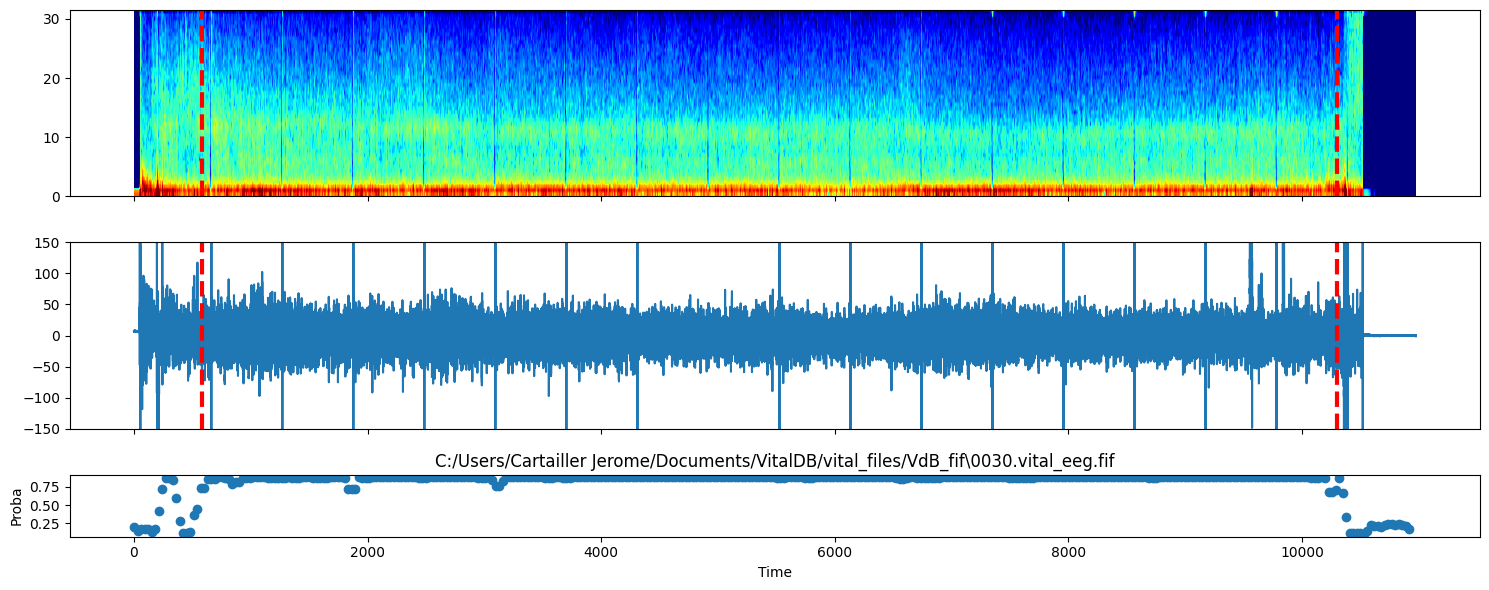

In [34]:
from boost_loc_roc.LoC_RoC import *

loc = []
roc = []
name = []
slope = []

for file in files[0:5]:
    filename = os.path.join(directory, file)
    
    # Unit check 
    check_and_rescale_units(filename, threshold=5, new_filename=filename)
    
    
    file_tmp = mne.io.read_raw_fif(filename)
    
    file_tmp = file_tmp.resample(63)
    file_tmp = Truncate_fif(file_tmp)
    duration_sec = file_tmp.n_times / file_tmp.info['sfreq']
    print('sfreq', file_tmp.info['sfreq'])

    if duration_sec > 5 * 60:
        # Extract sampling frequency and make a time vector
        Fs = file_tmp.info['sfreq']  # Hz
        time = np.linspace(0, file_tmp.get_data().shape[1]/Fs, file_tmp.get_data().shape[1], endpoint=False)
        Fp2 = file_tmp.get_data()[1,:]*10**6  # 10*6 because .fif is saved in Volts

        # Compute LoC and RoC
        time_loc, time_roc, t_proba, proba, LoC_params, RoC_params = extract_loc_roc(file_tmp)
        
        loc.append(time_loc)
        roc.append(time_roc)
        name.append(file)
        slope.append(LoC_params[0])
        
        # Visualize Spectrogram, EEG, and proba
        plot_spectrogram_debug(time_loc, time_roc, Fp2, Fs, time, t_proba, proba, LoC_params, RoC_params, filename)
        
df_label = pd.DataFrame({'id': name, 'LoC': loc, 'RoC': roc})

In [ ]:
df_label.head()